In [2]:
import scipy.io
import pandas as pd
import numpy as np
import os

# # Get all .mat files in the current working directory
# mat_files = [file for file in os.listdir() if file.endswith('.mat')]

# # Convert each .mat file to .csv
# for mat_file in mat_files:
#     # Load the .mat file
mat_file = 'dens_highvar_2000.mat'
mat_contents = scipy.io.loadmat(mat_file)

# Iterate over all variables in the loaded .mat file
for var_name in mat_contents:
    # Skip any __globals__, __version__, etc.
    if var_name.startswith('__'):
        continue
    
    # Get the variable
    data = mat_contents[var_name]
    
    # Check if the variable is a two-dimensional numerical array
    if isinstance(data, (np.ndarray, np.generic)) and data.ndim == 2:
        try:
            # If the array contains structured data, convert it into a regular 2D array of objects
            if data.dtype.names is not None:  # This means it's a structured array
                data = data.astype('object')

            # Convert to DataFrame
            print(data)
            df = pd.DataFrame(data)
            csv_file = mat_file.replace('.mat', f'_{var_name}.csv')
            df.to_csv(csv_file, index=False)
            print(f'Saved {csv_file}')
        except Exception as e:
            print(f'Error converting {var_name} in {mat_file}: {e}')
    else:
        print(f'Skipping {var_name} in {mat_file} as it is not a two-dimensional array or it contains non-numeric data.')


[[(array([[2.12304163e-10, 2.18002397e-10, 1.93540521e-10, ...,
          1.79873765e-10, 1.69222585e-10, 1.73319035e-10],
         [4.15468913e-11, 4.26384880e-11, 3.69791928e-11, ...,
          3.34133440e-11, 3.09033724e-11, 3.16802204e-11],
         [1.06908750e-11, 1.09667106e-11, 9.31444651e-12, ...,
          8.21130578e-12, 7.48387072e-12, 7.67910802e-12],
         ...,
         [1.91119717e-16, 1.94227338e-16, 2.01191404e-16, ...,
          2.15792913e-16, 2.18008832e-16, 2.19424794e-16],
         [1.79176828e-16, 1.82272915e-16, 1.89679517e-16, ...,
          2.04431135e-16, 2.06761270e-16, 2.08296170e-16],
         [1.68655011e-16, 1.71732644e-16, 1.79485045e-16, ...,
          1.94308832e-16, 1.96724840e-16, 1.98354505e-16]]), array([[2020],
         [2020],
         [2020],
         ...,
         [2223],
         [2224],
         [2224]], dtype=uint16), array([[ 3],
         [ 4],
         [ 5],
         ...,
         [12],
         [ 1],
         [ 2]], dtype=uint8), arra

In [3]:
data[0][0][0].shape


(37, 2448)

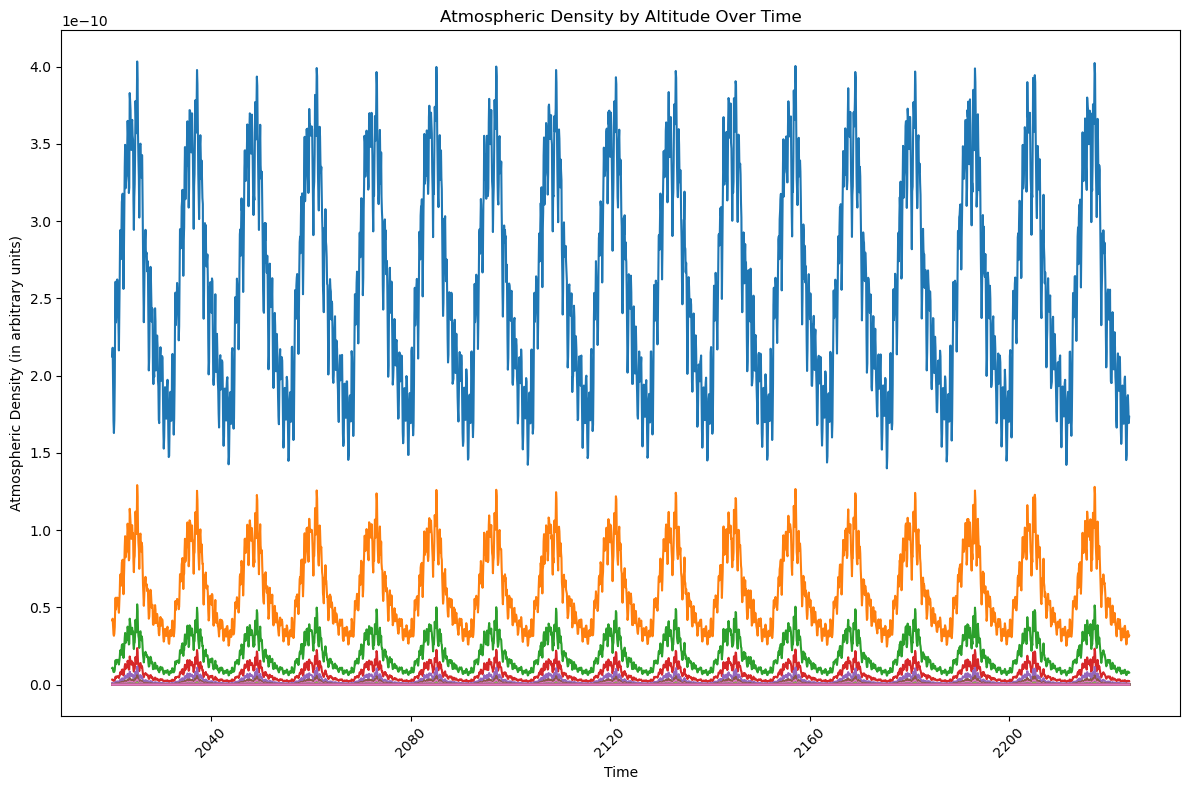

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Extract data from the structured array
density = data[0][0][0].T      # Density matrix
years = data[0][0][1].flatten()  # Years array, flattened
months = data[0][0][2].flatten() # Months array, flattened
altitudes = data[0][0][3].flatten() # Altitudes array, flattened

# Convert density data to a DataFrame
df_density = pd.DataFrame(density, columns=altitudes)

# Repeat the years and months for each altitude
time_data = {'Year': np.repeat(years, len(altitudes)),
             'Month': np.repeat(months, len(altitudes)),
             'Altitude': np.tile(altitudes, len(years))}

# Create a DataFrame for time and altitude data
df_time_altitude = pd.DataFrame(time_data)

# Flatten the density data to align with the time and altitude DataFrame
density_flat = df_density.values.flatten()
df_time_altitude['Density'] = density_flat

# Combine year and month into a datetime for better plotting
df_time_altitude['Time'] = pd.to_datetime(df_time_altitude['Year'].astype(str) + '-' + df_time_altitude['Month'].astype(str))

### Step 2: Plotting
plt.figure(figsize=(12, 8))
for altitude in sorted(df_time_altitude['Altitude'].unique()):
    subset = df_time_altitude[df_time_altitude['Altitude'] == altitude]
    plt.plot(subset['Time'], subset['Density'], label=f"{altitude} km")

plt.xlabel('Time')
plt.ylabel('Atmospheric Density (in arbitrary units)')
plt.title('Atmospheric Density by Altitude Over Time')
# plt.legend(title='Altitude')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

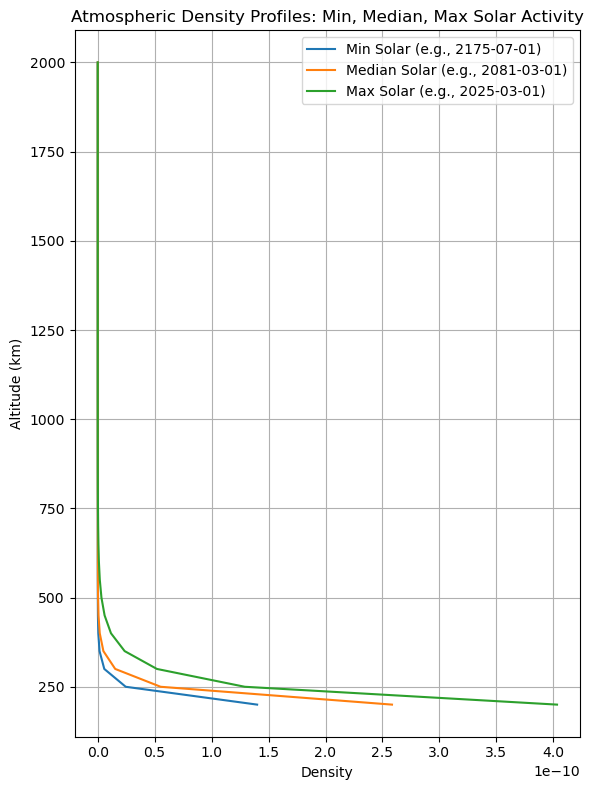

In [14]:
# Step 1: Average density over all altitudes per timestamp
mean_density_per_time = df_time_altitude.groupby('Time')['Density'].mean()

# Step 2: Identify timestamps for min, median, max solar activity proxies
time_min = mean_density_per_time.idxmin()
time_max = mean_density_per_time.idxmax()
time_median = mean_density_per_time.sort_values().index[len(mean_density_per_time) // 2]

# Step 3: Extract full vertical profiles at those times
profile_min = df_time_altitude[df_time_altitude['Time'] == time_min].sort_values('Altitude')
profile_median = df_time_altitude[df_time_altitude['Time'] == time_median].sort_values('Altitude')
profile_max = df_time_altitude[df_time_altitude['Time'] == time_max].sort_values('Altitude')

# Step 4: Plot them
plt.figure(figsize=(6, 8))
plt.plot(profile_min['Density'], profile_min['Altitude'], label=f"Min Solar (e.g., {time_min.date()})")
plt.plot(profile_median['Density'], profile_median['Altitude'], label=f"Median Solar (e.g., {time_median.date()})")
plt.plot(profile_max['Density'], profile_max['Altitude'], label=f"Max Solar (e.g., {time_max.date()})")
plt.xlabel("Density")
plt.ylabel("Altitude (km)")
plt.title("Atmospheric Density Profiles: Min, Median, Max Solar Activity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

,Year,Month,Altitude,Density,Time
27084,2081,3,200,2.583811e-10,2081-03-01
27085,2081,3,250,5.520264e-11,2081-03-01
27086,2081,3,300,1.534066e-11,2081-03-01
27087,2081,3,350,4.964659e-12,2081-03-01
27088,2081,3,400,1.760085e-12,2081-03-01
27089,2081,3,450,6.636416e-13,2081-03-01
27090,2081,3,500,2.637648e-13,2081-03-01
27091,2081,3,550,1.110813e-13,2081-03-01
27092,2081,3,600,5.034028e-14,2081-03-01
27093,2081,3,650,2.496753e-14,2081-03-01


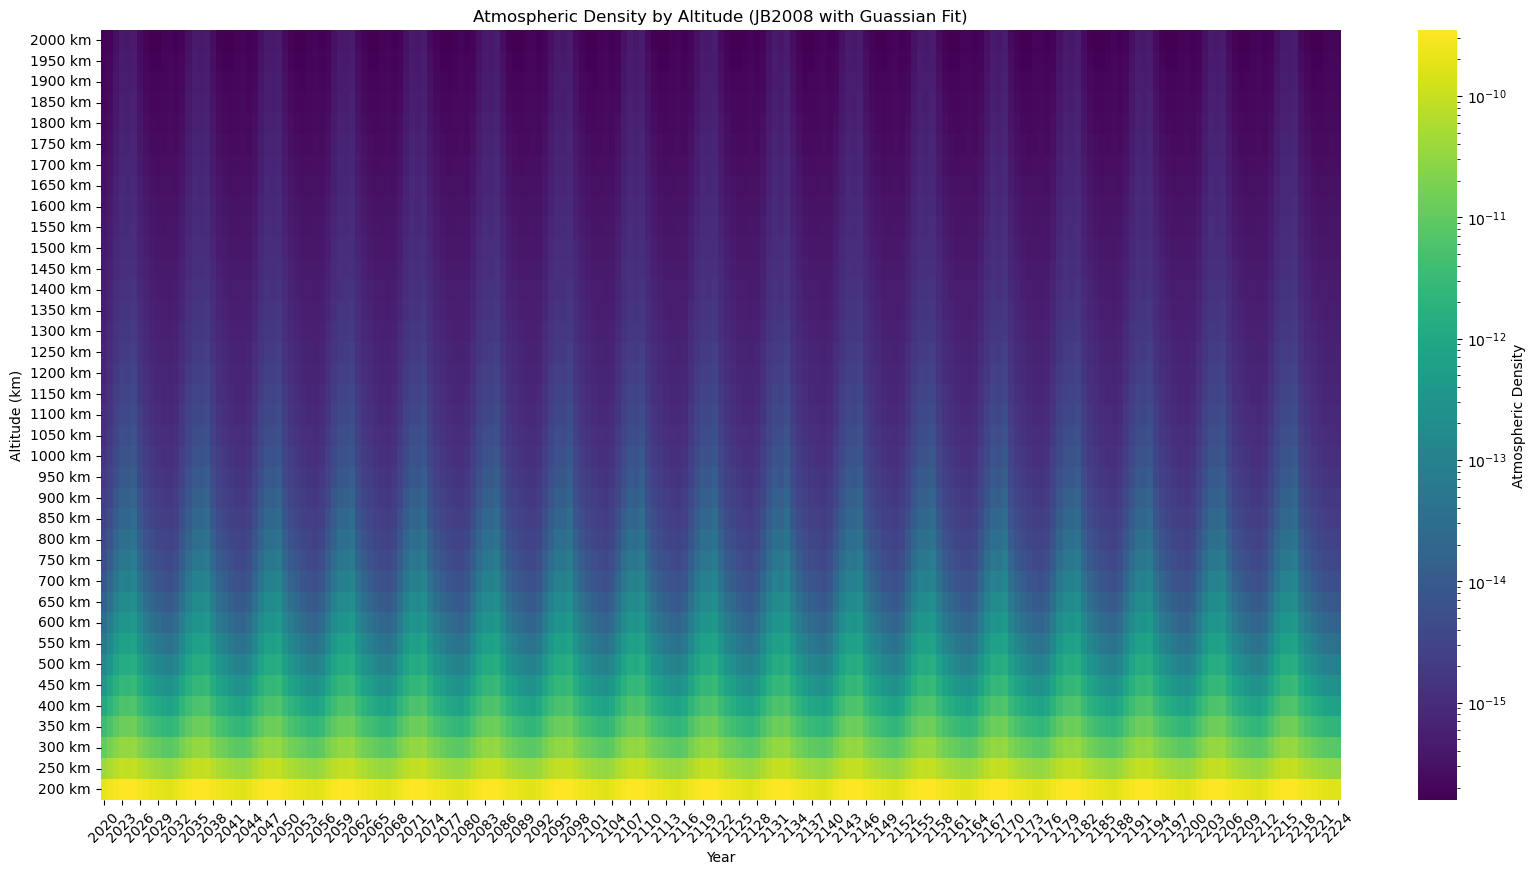

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

# Assuming your structured data variables are still accessible and correctly set
density = data[0][0][0].T      # Transpose the matrix so each column is a time point
years = data[0][0][1].flatten()  # Years array
months = data[0][0][2].flatten() # Months array
altitudes = data[0][0][3].flatten() # Altitudes array

# Create a DateTime index from years and months
dates = pd.to_datetime({'year': years, 'month': months, 'day': np.ones_like(years)})

# Create DataFrame
df_density = pd.DataFrame(density, index=dates, columns=[f"{alt} km" for alt in altitudes])

# Aggregate data by year for each altitude
df_yearly = df_density.groupby(df_density.index.year).mean().T  # Transpose to make altitudes as rows

# Ensure there are no zero or negative values for log scale
df_yearly[df_yearly <= 0] = np.nanmin(df_yearly[df_yearly > 0]) / 10  # Replace zeros or negatives with a small positive value

# Plotting the heatmap with altitudes on y-axis and years on x-axis
plt.figure(figsize=(20, 10))
ax = sns.heatmap(df_yearly, cmap="viridis", norm=LogNorm(vmin=df_yearly.min().min(), vmax=df_yearly.max().max()), cbar_kws={'label': 'Atmospheric Density'})

plt.title('Atmospheric Density by Altitude (JB2008 with Guassian Fit)')
plt.ylabel('Altitude (km)')
plt.xlabel('Year')
plt.xticks(rotation=45) 

ax.invert_yaxis()

plt.show()

In [6]:
# Create DataFrame
dates = pd.to_datetime({'year': years, 'month': months, 'day': np.ones_like(years)})
df_density = pd.DataFrame(density, index=dates, columns=[int(alt) for alt in altitudes])

# Group by year and month, averaging the data
df_monthly = df_density.groupby([df_density.index.year, df_density.index.month]).mean()

nested_density = {f"{year}-{month:02}": df_monthly.loc[(year, month)].to_dict()
                  for year, month in df_monthly.index}

In [7]:
import json

# Write the nested dictionary to a JSON file
with open('atmospheric_density_data.json', 'w') as f:
    json.dump(nested_density, f, indent=4)

# Notify the user
print("Data has been saved to 'atmospheric_density_data.json'.")

Data has been saved to 'atmospheric_density_data.json'.


In [8]:
with open('atmospheric_density_data.json', 'r') as f:
    loaded_density_data = json.load(f)

# Example of accessing the data
loaded_density_data['2120-03']

# print all keys for loaded_density_data['2120-03']

{'200': 3.701901121276578e-10,
 '250': 1.0310668556277763e-10,
 '300': 3.629341731333534e-11,
 '350': 1.461205259788397e-11,
 '400': 6.40393550457695e-12,
 '450': 2.9683154387749606e-12,
 '500': 1.4309141141003283e-12,
 '550': 7.111770980531647e-13,
 '600': 3.632907144450055e-13,
 '650': 1.9033911360156544e-13,
 '700': 1.0237540710564049e-13,
 '750': 5.706913977028235e-14,
 '800': 3.341065325551495e-14,
 '850': 2.070113527160246e-14,
 '900': 1.3575755230440466e-14,
 '950': 9.400339762562488e-15,
 '1000': 6.822690811437254e-15,
 '1050': 5.133141805244847e-15,
 '1100': 3.962106472809005e-15,
 '1150': 3.114559470205864e-15,
 '1200': 2.4801265091999173e-15,
 '1250': 1.9936589418536093e-15,
 '1300': 1.614575904645347e-15,
 '1350': 1.3660861108292811e-15,
 '1400': 1.1998277066138302e-15,
 '1450': 1.0657199013845344e-15,
 '1500': 9.57346208044473e-16,
 '1550': 8.654356684616787e-16,
 '1600': 7.832972938731854e-16,
 '1650': 7.097284555279451e-16,
 '1700': 6.437281127241955e-16,
 '1750': 5.8444

In [9]:
# create a np.array() that is 240 items long with random number between 0 and 100
import pandas as pd
import numpy as np
import json
from scipy.spatial import KDTree

# Load your density data from the JSON file
with open('atmospheric_density_data.json', 'r') as file:
    density_data = json.load(file)

# Prepare a KDTree for quick lookup of the closest altitude
# Extract unique altitudes from the keys of any month-year (assuming uniform across all entries)
sample_altitudes = list(density_data[next(iter(density_data))].keys())
altitude_values = np.array([int(alt.split()[0]) for alt in sample_altitudes])
altitude_tree = KDTree(altitude_values.reshape(-1, 1))

def get_density_values(altitudes, time):
    # Convert time to pandas datetime
    requested_date = pd.to_datetime(time)
    
    # Find the closest available date in the density data
    available_dates = pd.to_datetime(list(density_data.keys()))
    closest_date = available_dates[np.abs(available_dates - requested_date).argmin()].strftime('%Y-%m')
    
    # Output array for densities
    density_values = np.empty_like(altitudes, dtype=float)
    
    # Iterate over requested altitudes to find closest matches and corresponding densities
    for i, alt in enumerate(altitudes):
        closest_alt_idx = altitude_tree.query([alt])[1]  # Find closest altitude index
        closest_alt = f"{altitude_values[closest_alt_idx]}"  # Get altitude key
        density_values[i] = density_data[closest_date][closest_alt]
    
    return density_values

# Example Usage:
# Assuming the user has inputted a date and an array of altitudes
requested_time = '2023-04-15'
requested_altitudes = np.array([250, 750, 500, 600, 650, 1, 1500])
densities = get_density_values(requested_altitudes, requested_time)
print(densities) 

[1.04141742e-10 7.05111348e-14 1.60944974e-12 4.26749436e-13
 2.28116773e-13 3.64839901e-10 1.06816386e-15]


In [10]:
def JB2008_dens_func(t, h, scen_times_dates, start_date):
    """
    This will take in an array of species at different altitudes and then 
    will calulate the density at each altitude and return the new number of species in each shell.

    :param t: Time from t0
    :type t: int
    :param h: np.array of altitudes in km
    :type h: np.array
    :param scen_times_dates: A list of the scen_times in year-month format
    :type scen_times_dates: List of str. 
    :param start_date: The start date of the simulation, np.datetime format 
    """

    # Convert the start date to year-month format
    start_date = pd.to_datetime(start_date)

    # Calculate the target date based on the start date and timestep `t`
    target_date = start_date + pd.DateOffset(years=t)

    # Find the closest date in year-month format from the available dates
    time_str = min(scen_times_dates, key=lambda x: abs(pd.to_datetime(x) - target_date))

    # Load the density data
    path = os.path.join(os.path.dirname(__file__), 'dens_highvar_2000_dens_highvar_2000_lookup.json')

    with open(path, 'r') as file:
        density_data = json.load(file)

    # altitude_values = np.array([int(alt.split()[0]) for alt in h])
    altitude_tree = KDTree(h.reshape(-1, 1))

    available_dates = pd.to_datetime(list(density_data.keys()))
    closest_date = available_dates[np.abs(available_dates - time_str).argmin()].strftime('%Y-%m')
    
    # Output array for densities
    density_values = np.empty_like(h, dtype=float)
    
    for i, alt in enumerate(h):
        closest_alt_idx = altitude_tree.query([alt])[1]  
        closest_alt = f"{h[closest_alt_idx]}"  
        density_values[i] = density_data[closest_date][int(float(closest_alt))]

    return density_values

In [12]:
time_data

{'Year': array([2020, 2020, 2020, ..., 2224, 2224, 2224], dtype=uint16),
 'Month': array([3, 3, 3, ..., 2, 2, 2], dtype=uint8),
 'Altitude': array([ 200,  250,  300, ..., 1900, 1950, 2000], dtype=uint16)}